<a href="https://colab.research.google.com/github/MaruMarino/RNA-Clasificacion-pelotas-deporte/blob/main/RNA%20BACKPROPAGATION%20-%20Opcion2%20y%20RESTNET%20EFFICIENTNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNA BACKPROPAGATION**

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from keras.utils import np_utils

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


In [ ]:
## selección de los parámetros 

# 
#@markdown ### Parámetros de imágenes:
imagen_largo_ancho = 224 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
imagen_usar_generadas_data_augmentation = True # param {type:"boolean"}

#@markdown ### Parámetros de la red:
rna_cant_neuronas_capas_ocultas = '2400, 800,  620, 120, 10' #@param {type:"string"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]
rna_cant_epocas_entrenamiento = 200 #@param {type:"integer"}


## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# cantidad de neuronas ocultas 
##hidden_layers = [ num_inputs//5, num_inputs//20, num_inputs//100 ]
hidden_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(', '):
  if val == "D":
    hidden_layers.append( "DropOut" )  
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )  
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')

# cantidad de épocas del entrenamiento
cantEpocas = (100 if rna_cant_epocas_entrenamiento<1 else rna_cant_epocas_entrenamiento)

print ("Tamaño Imagen: ", IMAGE_SHAPE)
print("Configuración de RNA MLP Backpropagation definida: \n[", num_inputs, hidden_layers, ("Softmax" if tipo_output_softMax else "Dense[1] "))

Capa   620 descartada!
Tamaño Imagen:  (224, 224, 3)
Configuración de RNA MLP Backpropagation definida: 
[ 150528 ['2400', '800', '120', '10'] Softmax


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  1525
- Imágenes cargadas:  1525
- Ejemplo  bowling ball   (224, 224, 3) : 


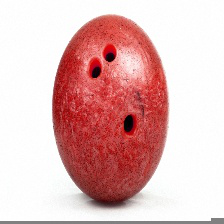



> Para Prueba: 
- Clases cargadas:  416
- Imágenes cargadas:  416
- Ejemplo  baseball   (224, 224, 3) : 


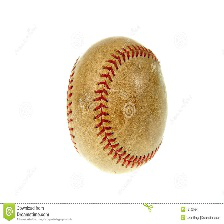

In [ ]:
#@title Cargar imágenes
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (1525, 150528)
 - y_trainEnc (cant):  1525


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (416, 150528)
 - y_testEnc (cant):  416


> Para Ambos: 
 - dictMapeo:  {'baseball': 0, 'cricket ball': 1, 'basketball': 2, 'wiffle ball': 3, 'volley ball': 4, 'water polo ball': 5, 'tennis ball': 6, 'football': 7, 'bowling ball': 8, 'paint balls': 9, 'golf ball': 10, 'soccer ball': 11, 'beachballs': 12, 'billiard ball': 13, 'cannon ball': 14}
 - clases_map:  ['baseball', 'cricket ball', 'basketball', 'wiffle ball', 'volley ball', 'water polo ball', 'tennis ball', 'football', 'bowling ball', 'paint balls', 'golf ball', 'soccer ball', 'beachballs', 'billiard ball', 'cannon ball']

 - Imagen reconstruida de  bowling ball ( 8  /  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] )


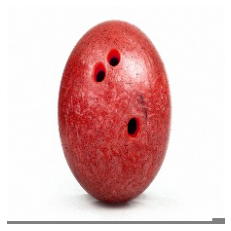

In [ ]:
#@title Preparar imágenes
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
if tipo_output_softMax:
  print(" - y_trainEnc (cant): ", len(y_trainEnc))
else:
  print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
if tipo_output_softMax:
  print(" - y_testEnc (cant): ", len(y_testEnc))
else:
  print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

Modelo creado con  6  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 150528)]          0         
_________________________________________________________________
hidd_1 (Dense)               (None, 2400)              361269600 
_________________________________________________________________
hidd_2 (Dense)               (None, 800)               1920800   
_________________________________________________________________
hidd_3 (Dense)               (None, 120)               96120     
_________________________________________________________________
hidd_4 (Dense)               (None, 10)                1210      
_________________________________________________________________
output (Dense)               (None, 15)                165       
Total params: 363,287,895
Trainable params: 363,287,895
Non-trainable params: 0
____________________

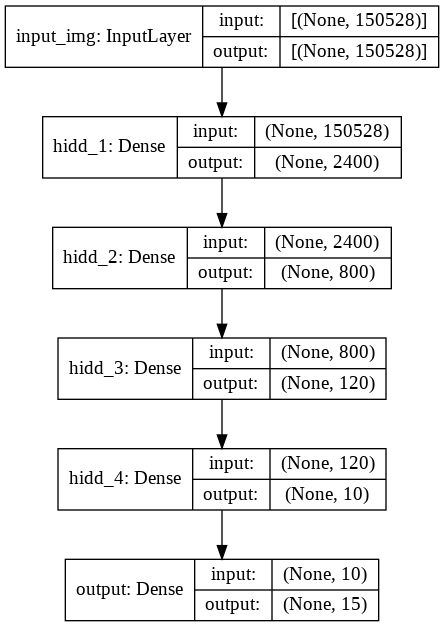

In [ ]:
#@title Establecer modelo

opt_tipo = "Gradiente Decreciente" # param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for val_hid in hidden_layers:  

  if val_hid == "DropOut":
    eachLay = Dropout(0.2)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn"+str(auxId)
    auxId = auxId + 1
    eachLay = BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = Dense(units = len(dictMapeo), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = Dense(1, activation=None, name='output')(eachLay) # capa de salida


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)

In [ ]:
#@title Entrenar

activar_corte_por_estabilidad_error_val = False 

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")


> De los  1525 ejemplos de entrenamiento: 
            se usan  1372 ejemplos para entrenar 
            y  153 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/200
43/43 [==============================] - 56s 1s/step - loss: 28.1557 - accuracy: 0.1050 - val_loss: 7.8989 - val_accuracy: 0.1765
Epoch 2/200
43/43 [==============================] - 56s 1s/step - loss: 7.3229 - accuracy: 0.1786 - val_loss: 3.1348 - val_accuracy: 0.2418
Epoch 3/200
43/43 [==============================] - 55s 1s/step - loss: 4.5172 - accuracy: 0.2238 - val_loss: 2.6452 - val_accuracy: 0.3007
Epoch 4/200
43/43 [==============================] - 56s 1s/step - loss: 2.9894 - accuracy: 0.2828 - val_loss: 2.6143 - val_accuracy: 0.2876
Epoch 5/200
43/43 [==============================] - 56s 1s/step - loss: 2.8342 - accuracy: 0.2959 - val_loss: 2.7389 - val_accuracy: 0.2745
Epoch 6/200
43/43 [==============================] - 56s 1s/step - loss: 2.5134 - accuracy: 0.3214 - val_loss: 3.4345 - val_accu

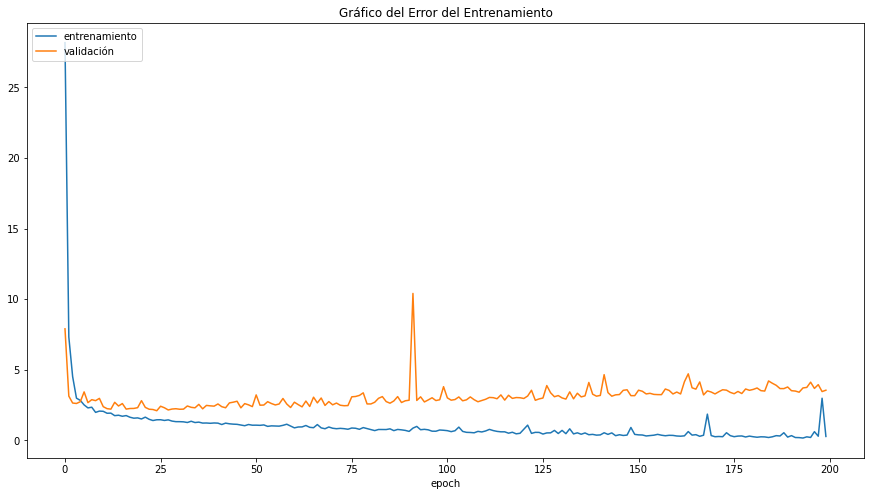

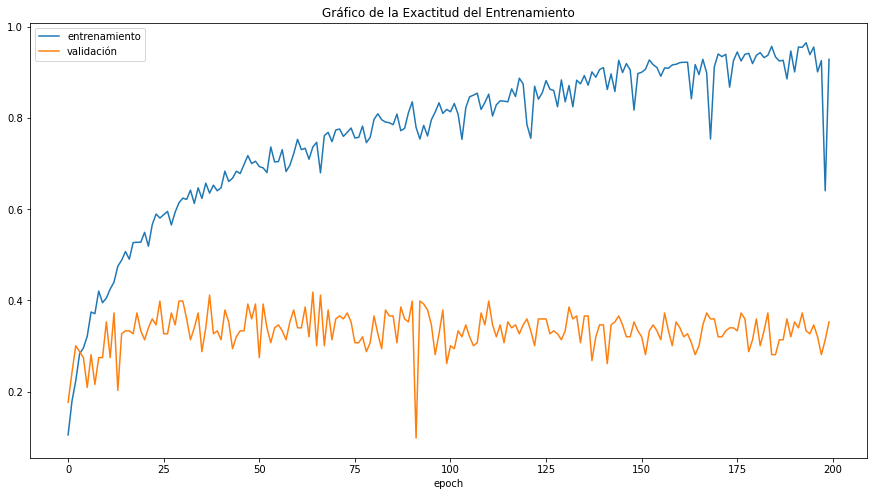

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [ ]:
#@title Probar red entrenada con datos de entrenamiento
mostrar_detalle_imagenes_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostrarImagenes=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        # sólo muestra las imágenes no generadas por DA
        if mostrarImagenes:
          strTitulo = 'Real: ' + clReal + ' / RNA: ' 
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )
          
          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    if mostrarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_imagenes_entrenamiento)

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
                 precision    recall  f1-score   support

       baseball       0.89      0.96      0.92        97
     basketball       0.94      0.94      0.94       100
     beachballs       0.81      0.93      0.87        80
  billiard ball       0.96      0.92      0.94       119
   bowling ball       0.96      0.66      0.78       125
    cannon ball       0.84      0.95      0.89       183
   cricket ball       0.91      0.91      0.91        70
       football       0.98      0.88      0.93        64
      golf ball       0.90      0.75      0.82        69
    paint balls       1.00      0.91      0.95        32
    soccer ball       0.94      0.90      0.92       167
    tennis ball       0.84      0.96      0.90       108
    volley ball       0.94      0.89      0.91       131
water polo ball       0.91      0.93      0.92       112
    wiffle ball       0.67      0.85      0.75        68

       accura

In [ ]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_imagenes_prueba = False #@param {type:"boolean"}
pd.set_option('display.max_columns', None)
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map, mostrar_detalle_imagenes_prueba)

13/13 [==============================] - 7s 534ms/step - loss: 3.5262 - accuracy: 0.3269

>Evaluación del Modelo: 
    - Error:  3.526228666305542
    - Exactitud:  32.692307233810425




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
                 precision    recall  f1-score   support

       baseball       0.21      0.30      0.24        20
     basketball       0.27      0.29      0.28        21
     beachballs       0.12      0.29      0.17        17
  billiard ball       0.38      0.21      0.27        29
   bowling ball       0.40      0.24      0.30        25
    cannon ball       0.05      0.60      0.09         5
   cricket ball       0.83      0.22      0.35        85
       football       0.82      0.26      0.40        53
      golf ball       0.75      0.36      0.48        42
    paint balls       0.00      0.00      0.00         5
    soccer ball       0.07      0.40      0.12         5
    tennis ball       0.55      0.75      0.64        36
    


# **ARQUITECTURAS RESNET Y EFFICIENTNET**



In [ ]:
import os 
import random
import matplotlib.image as mpimg 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')


from tensorflow.keras.layers import Input, Dense

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
os.listdir('/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas/train/')

['bowling ball',
 'cannon ball',
 'billiard ball',
 'baseball',
 'beachballs',
 'basketball',
 'cricket ball',
 'golf ball',
 'paint balls',
 'tennis ball',
 'football',
 'soccer ball',
 'water polo ball',
 'wiffle ball',
 'volley ball']

In [ ]:
balls_df = pd.read_csv('/content/gdrive/MyDrive/TPs IA/TP2/balls.csv')
balls_df.head()

,filepaths,labels,data set
0,train/baseball/001.jpg,baseball,train
1,train/baseball/002.jpg,baseball,train
2,train/baseball/003.jpg,baseball,train
3,train/baseball/004.jpg,baseball,train
4,train/baseball/005.jpg,baseball,train


In [ ]:
def showImages():
    """
    This function will plot any random image from the given dataset
    """
    random_index = random.choice(list(range(0, len(balls_df))))

    #image_path = '../input/balls-image-classification/balls/{}'.format(balls_df.iloc[random_index, :]['filepaths'])
    image_path = '/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas/{}'.format(balls_df.iloc[random_index, :]['filepaths'])
    print(image_path)
    image_dataset = balls_df.iloc[random_index, :]['data set']
    
    plt.imshow(mpimg.imread(image_path))
    plt.title(balls_df.iloc[random_index, :]['labels'])
    plt.axis(False)
    plt.xlabel(image_dataset)

NameError: ignored

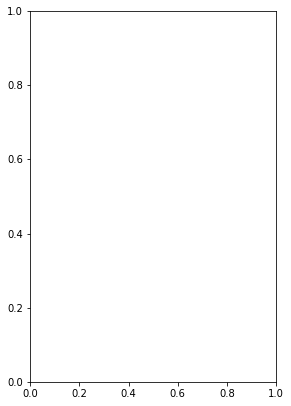

In [ ]:
plt.figure(figsize = (15,15))
for i in range(6):
    plt.subplot(2,3,i+1)
    showImages()

In [ ]:
## creating data loaders for preparing the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32 

train_dir = '/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas/train/'
test_dir = '/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas/test/'
val_dir = '/content/gdrive/MyDrive/TPs IA/TP2/imagenesPelotas/valid/'


# createing data generators 
train_datagen = ImageDataGenerator(rescale = 1 / 255.)
test_datagen = ImageDataGenerator(rescale = 1 / 255.)
valid_datagen = ImageDataGenerator(rescale = 1 / 255.)

print('Training Images')
train_data = train_datagen.flow_from_directory(
  train_dir,
  target_size = IMAGE_SHAPE,
  batch_size = BATCH_SIZE,
  class_mode = 'categorical'
)

print('Testing Images')
test_data = test_datagen.flow_from_directory(
  test_dir,
  target_size = IMAGE_SHAPE,
  batch_size = BATCH_SIZE,
  class_mode = 'categorical'
)

print('Validation images')
valid_data = test_datagen.flow_from_directory(
  val_dir,
  target_size = IMAGE_SHAPE,
  batch_size = BATCH_SIZE,
  class_mode = 'categorical'
)

Training Images
Found 1525 images belonging to 15 classes.
Testing Images
Found 416 images belonging to 15 classes.
Validation images
Found 75 images belonging to 15 classes.


In [ ]:
train_data.num_classes

24

In [ ]:
train_data.target_size

(224, 224)

In [ ]:
# importing the dependencies 
import tensorflow_hub as hub 
from tensorflow.keras import layers

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
# a function to create a model 
def create_model(model_url, num_classes = 24):
  # download the feature extractor model and save it 
    feature_extractor_layer = hub.KerasLayer(
      model_url,
      trainable = False, # freezes the already learned patterns 
      name = 'feature_extraction_layer',
      input_shape = IMAGE_SHAPE + (3,)
  )

  # model creation 
    model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(
        num_classes, 
        activation = 'softmax',
        name = 'output_layer'
    )
  ])

    return model 

In [ ]:
## function for plotting the loss curves 
def plot_loss(history):
    model_df = pd.DataFrame(history.history)
    loss = model_df.loss
    val_loss = model_df.val_loss
    accuracy = model_df.accuracy
    val_accuracy = model_df.val_accuracy

    epochs = range(len(model_df.loss))
    # plotting loss 
    plt.figure(figsize = (7,5))
    plt.title(
      'Loss'
    )
    plt.xlabel(
      'Epochs'
    )
    plt.plot(
      epochs,
      loss, 
      label = 'Training loss'
    )
    plt.plot(
      epochs, 
      val_loss, 
      label = 'Validation loss'
    )
    plt.legend()

  # plotting accuracy 
    plt.figure(figsize=(7,5))
    plt.title(
      'Accuracy'
    )
    plt.xlabel(
      'Epochs'
    )
    plt.plot(
      epochs, 
      accuracy,
      label = 'training accuracy',
    )
    plt.plot(
      epochs, 
      val_accuracy,
      label = 'validation accuracy'
    )
    plt.legend()
## creating and testing resnet model 
resnet_model = create_model(
    resnet_url,
    num_classes = train_data.num_classes
)

# compile the model 
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# fitting the model 
resnet_history = resnet_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = valid_data, 
    validation_steps = len(valid_data)
)

Epoch 1/5
48/48 [==============================] - 206s 4s/step - loss: 0.8990 - accuracy: 0.7416 - val_loss: 0.3137 - val_accuracy: 0.9333
Epoch 2/5
48/48 [==============================] - 187s 4s/step - loss: 0.1786 - accuracy: 0.9574 - val_loss: 0.2020 - val_accuracy: 0.9467
Epoch 3/5
48/48 [==============================] - 187s 4s/step - loss: 0.1055 - accuracy: 0.9810 - val_loss: 0.1800 - val_accuracy: 0.9467
Epoch 4/5
48/48 [==============================] - 188s 4s/step - loss: 0.0731 - accuracy: 0.9921 - val_loss: 0.1372 - val_accuracy: 0.9467
Epoch 5/5
48/48 [==============================] - 187s 4s/step - loss: 0.0548 - accuracy: 0.9967 - val_loss: 0.1326 - val_accuracy: 0.9467


In [ ]:
resnet_history


In [ ]:
resnet_model.evaluate(test_data)

13/13 [==============================] - 49s 4s/step - loss: 0.1445 - accuracy: 0.9591


[0.14449118077754974, 0.9591346383094788]

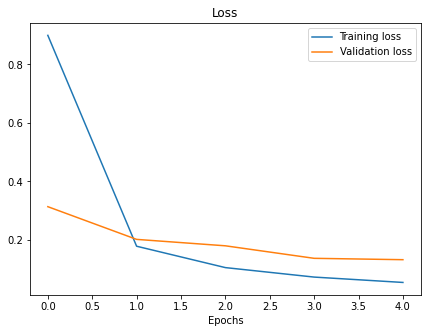

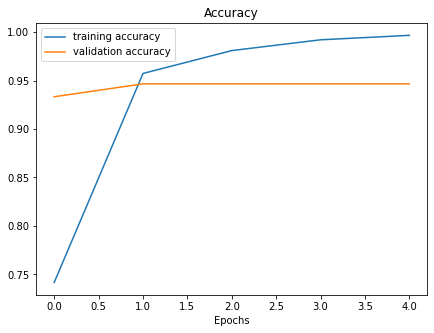

In [ ]:
plot_loss(resnet_history)

In [ ]:
# model creation
efficientnet_model = create_model(
    efficientnet_url,
    num_classes = train_data.num_classes
)

# compile the model 
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# fitting the model 
efficientnet_history = efficientnet_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data)
)

Epoch 1/5
90/90 [==============================] - 133s 1s/step - loss: 1.1457 - accuracy: 0.7773 - val_loss: 0.3617 - val_accuracy: 0.9500
Epoch 2/5
90/90 [==============================] - 123s 1s/step - loss: 0.2614 - accuracy: 0.9591 - val_loss: 0.1902 - val_accuracy: 0.9583
Epoch 3/5
90/90 [==============================] - 124s 1s/step - loss: 0.1564 - accuracy: 0.9780 - val_loss: 0.1309 - val_accuracy: 0.9833
Epoch 4/5
90/90 [==============================] - 124s 1s/step - loss: 0.1077 - accuracy: 0.9853 - val_loss: 0.1020 - val_accuracy: 0.9750
Epoch 5/5
90/90 [==============================] - 123s 1s/step - loss: 0.0801 - accuracy: 0.9916 - val_loss: 0.0908 - val_accuracy: 0.9833


In [ ]:
efficientnet_model.evaluate(test_data)

4/4 [==============================] - 26s 8s/step - loss: 0.1092 - accuracy: 0.9667


[0.10924219340085983, 0.9666666388511658]

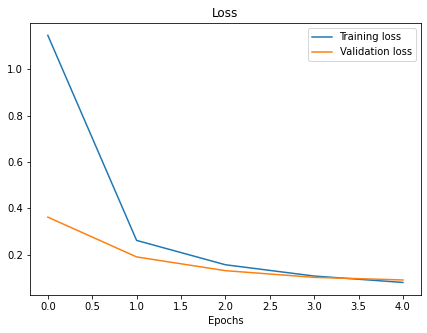

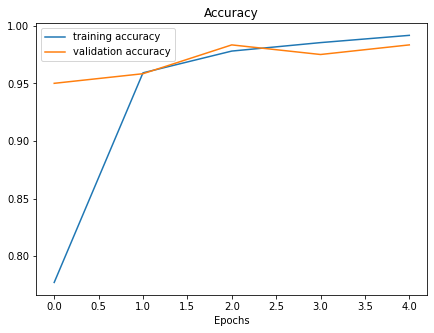

In [ ]:
plot_loss(efficientnet_history)